# Sandbox for testing FastSurfer model
- https://github.com/nikhil153/FastSurfer

In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dask import compute, delayed
import dask.multiprocessing


### Paths

In [2]:
project_dir = '../'
results_dir = '{}results/FastSurfer/'.format(project_dir)

In [3]:
def convert_mgz_to_nifti(mgz_file):
    nii_file = mgz_file.rsplit('.',1)[0] + '.nii.gz'
    mgh = nib.load(mgz_file)
    nib.save(mgh, nii_file)

def dice_coef(y_true, y_pred, smooth=1):
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    dice = np.mean((2. * intersection + smooth)/(union + smooth))
    return dice

def get_multi_label_dice(label_list, y_true, y_pred):
    ''' Calculates label-wise dice score for a 3D segmentation volume
    '''
    # # Dask based parallel compute
    values = [delayed(dice_coef)(y_true == label, y_pred == label) 
              for label in label_list]

    dice_list = compute(*values, scheduler='threads',num_workers=6) 
    dice_dict = dict(zip(label_list,dice_list)) 

    return pd.DataFrame(list(dice_dict.items()),columns=['label','dice'])

### Rough work

In [8]:
mgz_file = "/home/nikhil/Downloads/TaskRawWorkdir-FreeSurferReconAll-1807617-1/sub-2017717/mri/aparc.DKTatlas+aseg.mgz" #"/home/nikhil/Downloads/orig.mgz"   #aparc.DKTatlas+aseg.deep.mgz"
mgz_file = "/home/nikhil/Desktop/orig.mgz" 
convert_mgz_to_nifti(mgz_file)

In [7]:
FreeSurfer_label = "/home/nikhil/Downloads/TaskRawWorkdir-FreeSurferReconAll-1807617-1/sub-2017717/mri/aparc.DKTatlas+aseg.mgz"
FastSurfer_label = "/home/nikhil/Downloads/aparc.DKTatlas+aseg.deep.mgz"

fs_seg = nib.load(FreeSurfer_label).get_fdata()
deep_seg = nib.load(FastSurfer_label).get_fdata()
unique_labels = set(fs_seg.ravel())
print('{} unique labels found'.format(len(unique_labels)))
dice_df = get_multi_label_dice(unique_labels, fs_seg, deep_seg)

104 unique labels found


In [17]:
FastSurfer_label = "/home/nikhil/Downloads/aparc.DKTatlas+aseg.deep_prune_50.mgz"
deep_seg = nib.load(FastSurfer_label).get_fdata()
print('{} unique labels found'.format(len(unique_labels)))
dice_df_prune_50 = get_multi_label_dice(unique_labels, fs_seg, deep_seg)

104 unique labels found


In [18]:
dice_df['prunning'] = 'orig'
dice_df_prune_50['prunning'] = '50%'

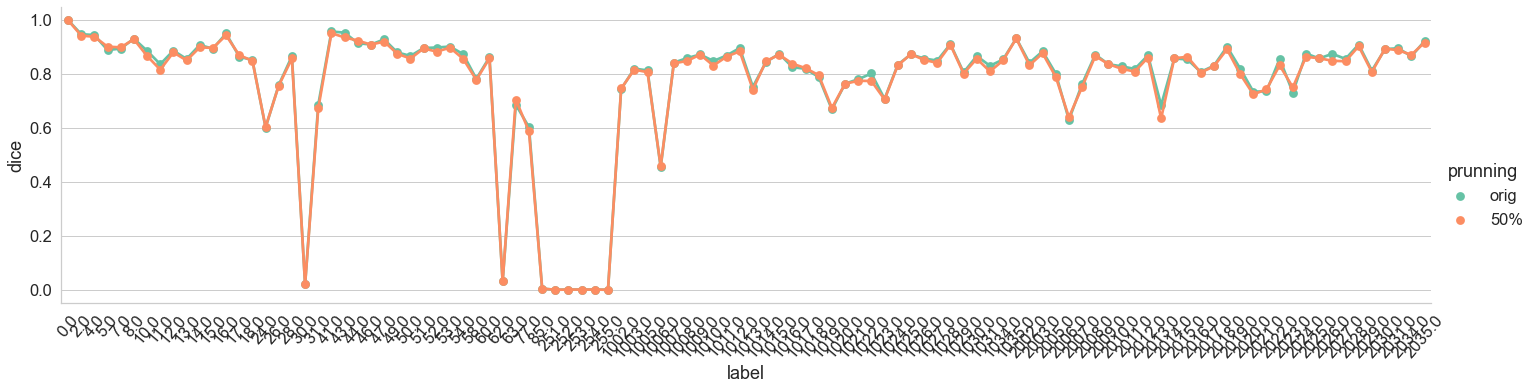

In [19]:
plot_df = dice_df.append(dice_df_prune_50)
plot_df = plot_df.sort_values(['label'])
plot_df['label'] = plot_df['label'].astype(str)
sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='label',y='dice', hue='prunning', kind='point', data=plot_df, palette='Set2',height=5, aspect=4, sharex=True, sharey=True)
    g.set_xticklabels(rotation=50)

In [4]:
FreeSurfer_label_dir = '/home/nikhil/projects/Parkinsons/data/fs60/segmentations/'
FastSurfer_label_dir = '/home/nikhil/projects/green_comp_neuro/FastSurfer/data/'

cohort = 'ET'
prunnings = ['prune_10','prune_25','prune_50','prune_75','prune_90']
save_perf = True
for prunning in prunnings:
    FreeSurfer_subjects = os.listdir('{}{}'.format(FreeSurfer_label_dir,cohort))
    FastSurfer_subjects = os.listdir('{}{}/{}'.format(FastSurfer_label_dir,prunning,cohort))
    common_subject = list(set(FastSurfer_subjects) & set(FreeSurfer_subjects))

    print('n subjects, FreeSurfer:{}, FastSurfer:{}, common:{}'.format(len(FreeSurfer_subjects), len(FastSurfer_subjects), len(common_subject)))

    dice_df_concat = pd.DataFrame()
    for s, sub in enumerate(common_subject):
        print('Subject id: {},{}'.format(s,sub))
        FreeSurfer_label = FreeSurfer_label_dir + '{}/{}/aparc.DKTatlas+aseg.mgz'.format(cohort,sub)
        FastSurfer_label = FastSurfer_label_dir + '{}/{}/{}/aparc.DKTatlas+aseg.deep.mgz'.format(prunning,cohort,sub)

        fs_seg = nib.load(FreeSurfer_label).get_fdata()
        deep_seg = nib.load(FastSurfer_label).get_fdata()

        if s == 0:
            unique_labels = set(fs_seg.ravel())
            print('{} unique labels found'.format(len(unique_labels)))

        dice_df = get_multi_label_dice(unique_labels, fs_seg, deep_seg)
        dice_df['prunning'] = prunning
        dice_df['cohort'] = cohort
        dice_df['subject_id'] = sub
        dice_df_concat = dice_df_concat.append(dice_df)

        if save_perf:
            dice_csv = results_dir + '{}/{}/dice_perf.csv'.format(prunning, cohort)
            dice_df_concat.to_csv(dice_csv)




n subjects, FreeSurfer:40, FastSurfer:40, common:40
Subject id: 0,sub-4300
108 unique labels found
Subject id: 1,sub-0081
Subject id: 2,sub-1012
Subject id: 3,sub-1160
Subject id: 4,sub-0143
Subject id: 5,sub-1500
Subject id: 6,sub-0145
Subject id: 7,sub-0142
Subject id: 8,sub-0119
Subject id: 9,sub-0115
Subject id: 10,sub-1890
Subject id: 11,sub-3700
Subject id: 12,sub-1120
Subject id: 13,sub-7400
Subject id: 14,sub-0144
Subject id: 15,sub-0147
Subject id: 16,sub-3900
Subject id: 17,sub-1230
Subject id: 18,sub-0141
Subject id: 19,sub-4700
Subject id: 20,sub-1310
Subject id: 21,sub-7800
Subject id: 22,sub-1920
Subject id: 23,sub-0139
Subject id: 24,sub-0178
Subject id: 25,sub-7000
Subject id: 26,sub-0140
Subject id: 27,sub-2400
Subject id: 28,sub-8000
Subject id: 29,sub-4200
Subject id: 30,sub-1340
Subject id: 31,sub-3600
Subject id: 32,sub-1690
Subject id: 33,sub-0134
Subject id: 34,sub-5700
Subject id: 35,sub-0146
Subject id: 36,sub-1450
Subject id: 37,sub-0122
Subject id: 38,sub-001

## Load previously saved perf

In [5]:
dice_df_concat = pd.DataFrame()
cohorts = ['NC','ET','PD'] #,'ET','PD']
prunnings = ['orig', 'prune_10', 'prune_25', 'prune_50', 'prune_75','prune_90'] #
for prunning in prunnings:
    for cohort in cohorts:
        dice_csv = results_dir + '{}/{}/dice_perf.csv'.format(prunning,cohort)
        dice_df = pd.read_csv(dice_csv)
        dice_df['prunning'] = prunning
        dice_df_concat = dice_df_concat.append(dice_df)

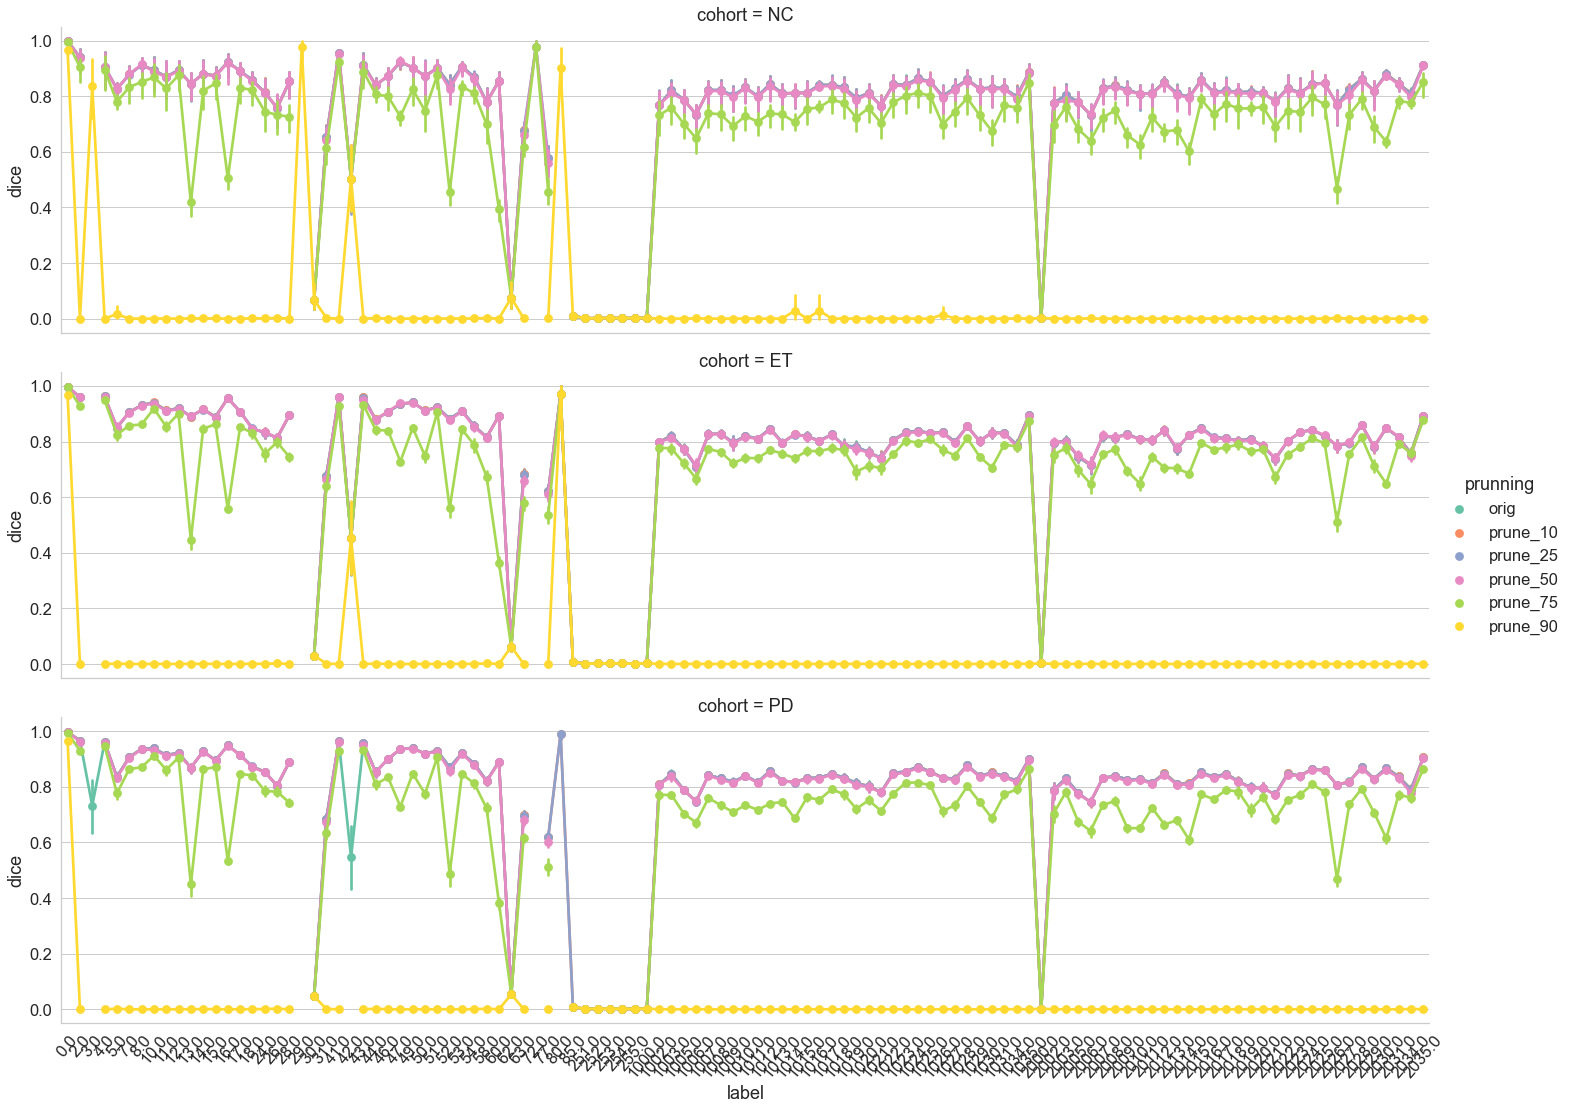

In [11]:
plot_df = dice_df_concat.copy()
plot_df = plot_df.sort_values(['label'])
plot_df['label'] = plot_df['label'].astype(str)
hue_order = prunnings
sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='label',y='dice', hue='prunning', col='cohort', col_wrap=1, kind='point', hue_order=hue_order ,data=plot_df, palette='Set2',height=5, aspect=4, sharex=True, sharey=True)
    g.set_xticklabels(rotation=50)


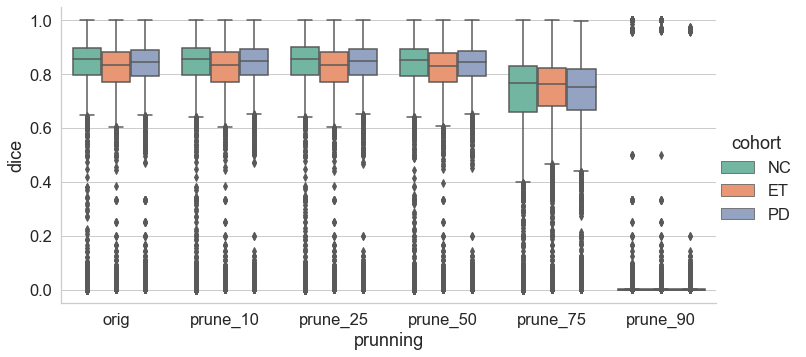

In [12]:
plot_df = dice_df_concat.copy()
plot_df = plot_df.sort_values(['label'])
plot_df['label'] = plot_df['label'].astype(str)

sns.set(font_scale = 1.5)
hue_order = cohorts
x_order = prunnings
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='prunning',y='dice', hue='cohort', kind='box', data=plot_df, palette='Set2', order=x_order, hue_order=hue_order, height=5, aspect=2, sharex=True, sharey=True)
    


In [35]:
dice_thesh = 0.5
label_df = dice_df_concat[dice_df_concat['prunning']=='orig'].groupby(['label']).median().reset_index()
stable_ROIs = label_df[label_df['dice']>dice_thesh]['label'].unique()
print(len(stable_ROIs))

98


(81205, 6)
(65479, 6)


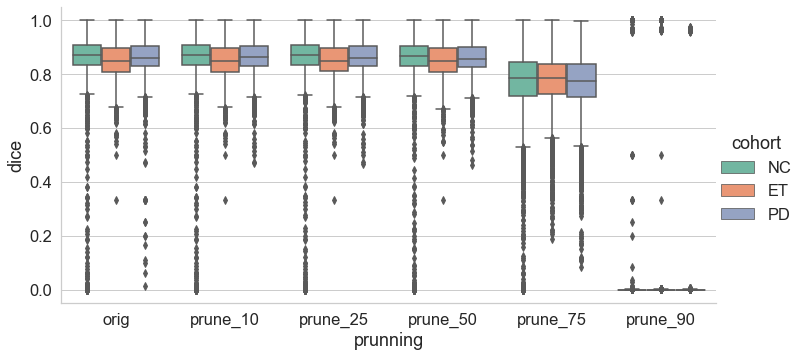

In [34]:
plot_df = dice_df_concat.copy()
print(plot_df.shape)
plot_df = plot_df[plot_df['label'].isin(stable_ROIs)]
print(plot_df.shape)
plot_df = plot_df.sort_values(['label'])
plot_df['label'] = plot_df['label'].astype(str)

sns.set(font_scale = 1.5)
hue_order = cohorts
x_order = prunnings
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='prunning',y='dice', hue='cohort', kind='box', data=plot_df, palette='Set2', order=x_order, hue_order=hue_order, height=5, aspect=2, sharex=True, sharey=True)

In [14]:
40000/60/24

27.777777777777775

In [16]:
40000*72/(3600)/24

33.333333333333336